In [214]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from matplotlib import pyplot as plt
import numpy as np

In [215]:
cds_r = pd.read_json('Data/reviews_CDs_and_Vinyl_5.json', lines=True)

In [216]:
X = cds_r['reviewText']
y = cds_r['overall']

## Exploratory Data Analysis

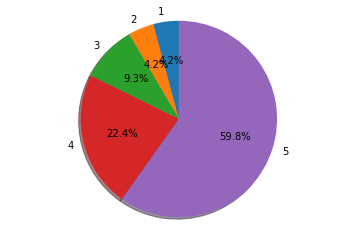

In [217]:
label_counts = pd.value_counts(y.values, sort=False)
fig1, ax1 = plt.subplots()
ax1.pie(label_counts.values, labels=list(label_counts.keys()),shadow=True, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.show()

## Base Model: Naive Bayes

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [219]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.values)

In [220]:
X_test_counts = count_vect.transform(X_test.values)

In [221]:
clf = MultinomialNB()
clf.fit(X_train_counts, y_train)
predicted = clf.predict(X_test_counts)
print(clf.score(X_test_counts, y_test))

0.638675229013324


## Base Model: SVM

In [222]:
from sklearn.linear_model import SGDClassifier

In [223]:
clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None)

clf.fit(X_train_counts, y_train)  
predicted = clf.predict(X_test_counts)
np.mean(predicted == y_test)      

0.6545584556854387

## Word2vec

In [224]:
import gensim

In [5]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [225]:
embedding_size = model.vector_size

In [226]:
def sentence_to_vect(review, max_review_length):
    sent_vector = []
    for word in review.split():
        if word in model.vocab:
            sent_vector.append(model[word])
    if len(sent_vector) < max_review_length:
        tmp = [0]*embedding_size
        sent_vector.extend([tmp for _ in range(max_review_length-len(sent_vector))])
    return sent_vector

In [227]:
def get_data_vectors(data):
    max_review_length = 0
    for r in data:
        words = r.split()
        if len(words) > max_review_length:
            max_review_length = len(words)
    vectorized_data = []
    for review in data:
        vectorized_data.append(sentence_to_vect(review, max_review_length))
    return np.array(vectorized_data), max_review_length

In [ ]:
training_data, _ = get_data_vectors(X_train)

In [ ]:
test_data, _ = get_data_vectors(X_test)

## CNN

In [ ]:
import tensorflow as tf

In [ ]:
def cnn_model_fn(features, labels, mode):
    # Input Layer
    #input_layer = tf.reshape(tf.to_float(features), [-1, params['max_review_length'], embedding_size])
    input_layer = tf.to_float(features)
    # Convolutional Layer #1
    pool_outs = []
    for filter_shape in [3,4,5]:
        conv = tf.layers.conv1d(inputs=input_layer,filters=2, kernel_size=filter_shape, strides=1, padding="valid", activation=tf.nn.relu)
        pool_outs.append(tf.reduce_max(conv, axis=1))
    conv_pool_output = tf.concat(pool_outs,axis=1)
    # Dense Layer
    #conv_pool_output_flat = tf.reshape(conv_pool_output, [-1, conv_pool_output.shape[0] * conv_pool_output.shape[1]])
    #print(conv_pool_output_flat)
    dense = tf.layers.dense(inputs=conv_pool_output, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=5)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [ ]:
# Create the Estimator
sentiment_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, 
                                              model_dir="checkpoint/sentiment_classifier_convnet_model")
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [ ]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(x=training_data,y=y_train.values-1, batch_size=10, shuffle=True, num_epochs=None)
sentiment_classifier.train(input_fn=train_input_fn,steps=200,hooks=[logging_hook])

In [ ]:
# Evaluate the model and print results
max_review_length = max_review_length_test
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x=test_data,y=y_test.values-1,num_epochs=1,shuffle=False)
eval_results = sentiment_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)